In [1]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
import sys

# Add the project directory to sys.path
project_dir = Path.cwd().parent  # Adjust as needed to point to your project root
sys.path.append(str(project_dir))

print("project_dir: ", project_dir)
from utils.pipeline_fixed import Pipeline, EvaluationEnum

dataloader = Pipeline(evaluation=EvaluationEnum.LAST)

file_tag = "economic"
eval_metric = "accuracy"

trnX, tstX, trnY, tstY, target, labels = dataloader.get_economical_classification_train_test()

project_dir:  /Users/jesseoomen/Documents/jaar_3/kdd-process/src


In [2]:
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from utils.dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from utils.dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart




Train#=5656 Test#=735
Labels=[0 1]
GB best for 100 trees (d=5 and lr=0.7


<Figure size 640x480 with 0 Axes>

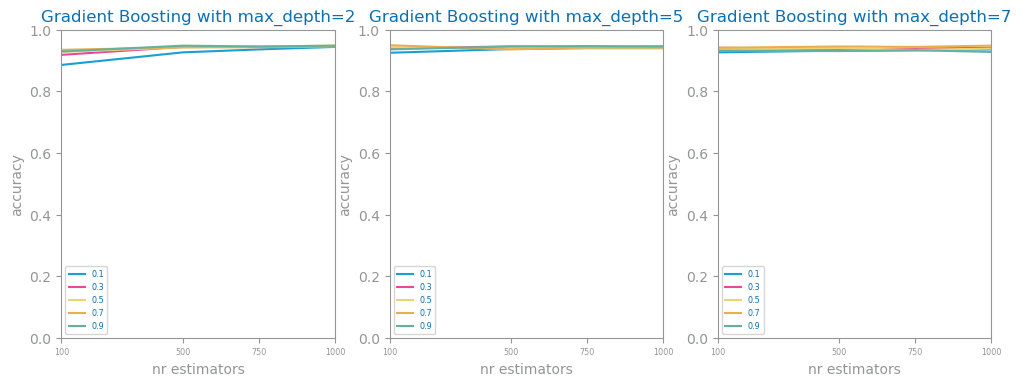

In [3]:
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from utils.dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from utils.dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart


def gradient_boosting_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[GradientBoostingClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    learning_rates: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: GradientBoostingClassifier | None = None
    best_params: dict = {"name": "GB", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for lr in learning_rates:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = GradientBoostingClassifier(
                    n_estimators=n, max_depth=d, learning_rate=lr
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, lr, n)
                    best_model = clf
                # print(f'GB d={d} lr={lr} n={n}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Gradient Boosting with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'GB best for {best_params["params"][2]} trees (d={best_params["params"][0]} and lr={best_params["params"][1]}'
    )

    return best_model, best_params

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = gradient_boosting_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"images/{file_tag}_gb_{eval_metric}_study.png")

# Best model performance

<Figure size 640x480 with 0 Axes>

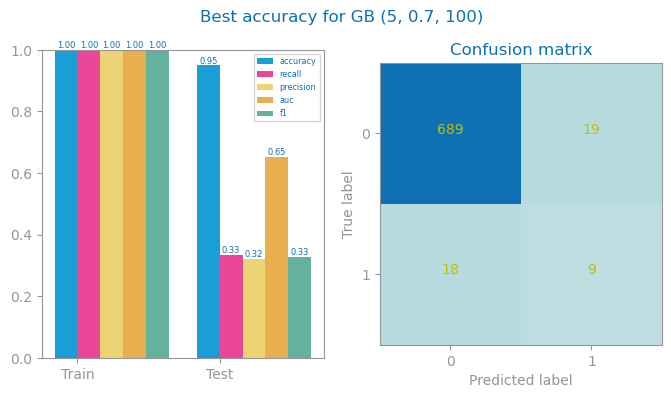

In [4]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_gb_{params["name"]}_best_{params["metric"]}_eval.png')
show()

# Variable importance 

1. x12 (0.6082075822242498)
2. x47 (0.10547208230713295)
3. x51 (0.028845992461527754)
4. x58 (0.026014389707227213)
5. x11 (0.022696496632237946)
6. x42 (0.021336146499079993)
7. x66 (0.019034638938040603)
8. x26 (0.017063762180587617)
9. x74 (0.015955029959253245)
10. x80 (0.013345350220200452)
11. x17 (0.011340578828098679)
12. x37 (0.010799333592015143)
13. x6 (0.010258868740090245)
14. x21 (0.008395168883781617)
15. x54 (0.008154221608361756)
16. x72 (0.007741860848755542)
17. x60 (0.0070050643738422645)
18. x27 (0.0064712998075787875)
19. x31 (0.0062580137552148704)
20. x57 (0.005258889961357818)
21. x82 (0.003973022151524827)
22. x56 (0.003937234230033692)
23. x55 (0.0037366345082636985)
24. Company (0.003606483697329971)
25. x28 (0.0035346857063325637)
26. x65 (0.00295492090492434)
27. x29 (0.0022464124777710156)
28. x15 (0.0021751865044109505)
29. x39 (0.0021559750074470964)
30. x83 (0.0019458172593065952)
31. x45 (0.0018736204993459204)
32. x69 (0.0015987269735978774)
33. x18

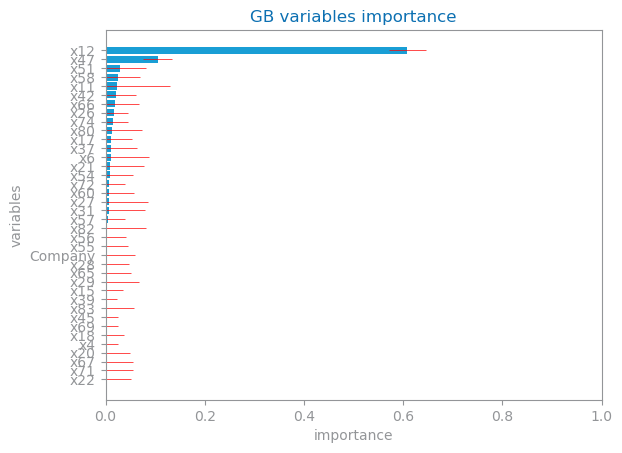

In [5]:
from numpy import std, argsort
from utils.dslabs_functions import plot_horizontal_bar_chart

trees_importances: list[float] = []
for lst_trees in best_model.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []

feature_names = trnX.columns 
for f in range(len(feature_names)):
    feature_f = feature_names[indices[f]]
    feature_imp = importances[indices[f]]

    elems.append(feature_f)
    imp_values.append(feature_imp)
    print(f"{f+1}. {feature_f} ({feature_imp})")
    
figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="GB variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{eval_metric}_vars_ranking.png")

# Overfitting study

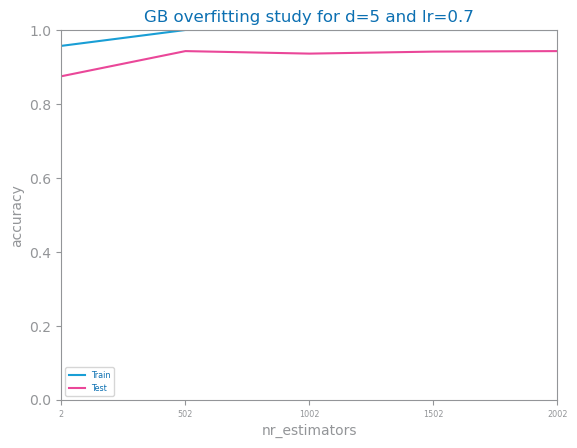

In [6]:
d_max: int = params["params"][0]
lr: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{eval_metric}_overfitting.png")